In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
path = 'data/mod_05_topic_10_various_data.pkl'

with open(path, 'rb') as file:
    data = pickle.load(file)

df = data['autos']

df['stroke_ratio'] = df['stroke'] / df['bore']
df['make_and_style'] = df['make'] + '_' + df['body_style']
df['mpg_avg'] = df['city_mpg'] + df['highway_mpg'] / 2
df['engine_economy'] = df['horsepower'] / df['mpg_avg']
df['econom_car'] = df['city_mpg'] < df.city_mpg.median()

df.sample(5)

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,horsepower,peak_rpm,city_mpg,highway_mpg,price,stroke_ratio,make_and_style,mpg_avg,engine_economy,econom_car
47,mazda,gas,std,2,hatchback,fwd,front,93.1,159.1,64.2,...,68,5000,31,38,6095,1.039604,mazda_hatchback,50.0,1.360000,False
58,mercedes-benz,diesel,turbo,4,sedan,rwd,front,110.0,190.9,70.3,...,123,4350,22,25,25552,1.016760,mercedes-benz_sedan,34.5,3.565217,True
88,nissan,gas,std,4,wagon,fwd,front,94.5,170.2,63.8,...,69,5200,31,37,7999,1.044444,nissan_wagon,49.5,1.393939,False
50,mazda,gas,std,4,sedan,fwd,front,93.1,166.8,64.2,...,68,5000,31,38,7395,1.022727,mazda_sedan,50.0,1.360000,False
33,honda,gas,std,4,sedan,fwd,front,96.5,163.4,64.0,...,76,6000,30,34,7295,1.171821,honda_sedan,47.0,1.617021,False


In [3]:
cat_features = df.select_dtypes('object').columns
cat_features = cat_features.to_list() + ['num_of_doors', 'num_of_cylinders']

In [4]:
for colname in cat_features:
    df[colname], _ = df[colname].factorize()

In [5]:
df

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,horsepower,peak_rpm,city_mpg,highway_mpg,price,stroke_ratio,make_and_style,mpg_avg,engine_economy,econom_car
0,0,0,0,0,0,0,0,88.6,168.8,64.1,...,111,5000,21,27,13495,0.772334,0,34.5,3.217391,True
1,0,0,0,0,0,0,0,88.6,168.8,64.1,...,111,5000,21,27,16500,0.772334,0,34.5,3.217391,True
2,0,0,0,0,1,0,0,94.5,171.2,65.5,...,154,5000,19,26,16500,1.294776,1,32.0,4.812500,True
3,1,0,0,1,2,1,0,99.8,176.6,66.2,...,102,5500,24,30,13950,1.065831,2,39.0,2.615385,True
4,1,0,0,1,2,2,0,99.4,176.6,66.4,...,115,5500,18,22,17450,1.065831,2,29.0,3.965517,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,20,0,0,1,2,0,0,109.1,188.8,68.9,...,114,5400,23,28,16845,0.833333,51,37.0,3.081081,True
189,20,0,1,1,2,0,0,109.1,188.8,68.8,...,160,5300,19,25,19045,0.833333,51,31.5,5.079365,True
190,20,0,0,1,2,0,0,109.1,188.8,68.9,...,134,5500,18,23,21485,0.801676,51,29.5,4.542373,True
191,20,1,1,1,2,0,0,109.1,188.8,68.9,...,106,4800,26,27,22470,1.129568,51,39.5,2.683544,False


In [6]:
def xi_correlation(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Ранжування значень
    rx = rankdata(x)
    ry = rankdata(y)
    
    # Обчислення коефіцієнта ξ
    numerator = np.sum(np.abs(rx - ry))
    denominator = np.sum(np.abs(rx - np.median(rx))) + np.sum(np.abs(ry - np.median(ry)))
    
    return 1 - (numerator / denominator)

def calculate_correlations(df: pd.DataFrame, target_col: str, is_classification=True, plot: bool=False, discrete_cols: list=[]):
    if target_col not in df.columns:
        raise ValueError("Target column not found in DataFrame")
    
    correlations = {
        "Feature": [],
        "Pearson_corr": [],
        "Spearman_corr": [],
        "Mutual_Info": [],
        "Forest_Importance": [],
        "Xi_corr": []
    }
    
    target = df[target_col]
    X = df.drop(columns=[target_col])
    y = target
    
    model = RandomForestClassifier() if is_classification else RandomForestRegressor()
    model.fit(X, y)
    feature_importances = model.feature_importances_
    
    for i, col in enumerate(X.columns, start=0):
        pearson_corr = df[col].corr(target, method='pearson')
        spearman_corr = df[col].corr(target, method='spearman')
        
        mi_func = mutual_info_classif if is_classification else mutual_info_regression
        mutual_info = mi_func(df[[col]], target, discrete_features=col in discrete_cols)[0]
        
        xi_corr = xi_correlation(df[col].values, target.values)
        
        correlations["Feature"].append(col)
        correlations["Pearson_corr"].append(pearson_corr)
        correlations["Spearman_corr"].append(spearman_corr)
        correlations["Mutual_Info"].append(mutual_info)
        correlations["Forest_Importance"].append(feature_importances[i])
        correlations["Xi_corr"].append(xi_corr)
    
    result_df = pd.DataFrame(correlations)
    graph_df = result_df.copy()
    for metric in graph_df.drop('Feature', axis=1).columns:
        graph_df[metric] = np.abs(graph_df[metric])
        graph_df[metric] = graph_df[metric].rank(pct=True)

    graph_df["Mean_Rank"] = graph_df.drop(columns=["Feature"]).mean(axis=1)
    top_features = graph_df.nlargest(10, "Mean_Rank")["Feature"].tolist()
    print(f"Top 10 features: {top_features}")
    
    if plot:
        graph_df = graph_df.sort_values(by='Mean_Rank', ascending=True)
        graph_df = graph_df.tail(10)
        graph_df.set_index("Feature").plot(kind='barh', figsize=(12, 12))
        plt.title("Feature Correlations")
        plt.ylabel("Correlation / Mutual Information")
        plt.xlabel("Features")
        plt.legend(title="Metric")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    return result_df


Top 10 features: ['curb_weight', 'engine_economy', 'engine_size', 'horsepower', 'width', 'length', 'highway_mpg', 'wheel_base', 'mpg_avg', 'num_of_cylinders']


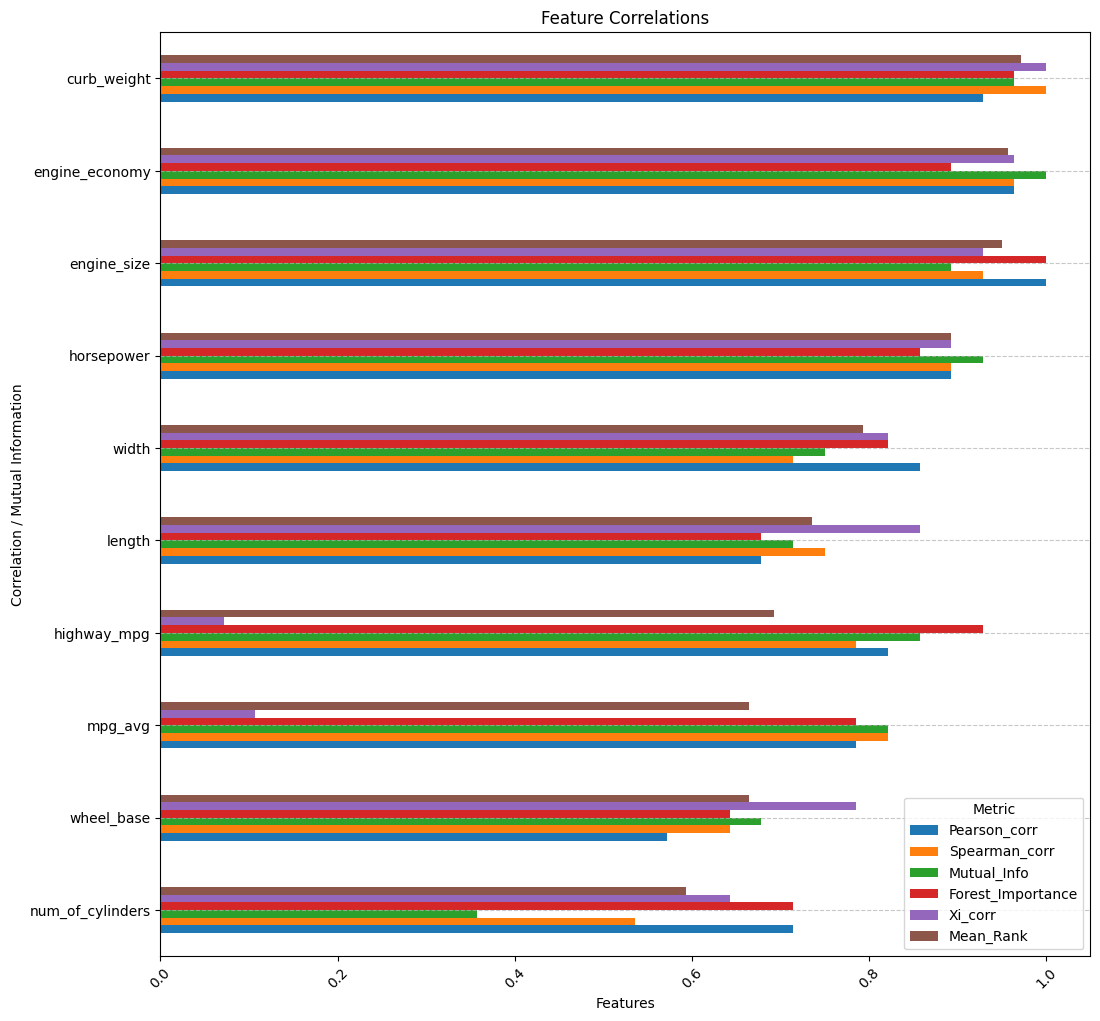

,Feature,Pearson_corr,Spearman_corr,Mutual_Info,Forest_Importance,Xi_corr
0,make,-0.165066,-0.011653,0.546129,0.006426,0.328100
1,fuel_type,0.115440,0.149841,0.048120,0.001114,0.143959
2,aspiration,0.186073,0.319209,0.087994,0.001135,0.290989
3,num_of_doors,0.046460,0.148214,0.012234,0.000469,0.379689
4,body_style,0.185076,0.227459,0.079378,0.002258,0.374796
5,drive_wheels,-0.596227,-0.642947,0.333404,0.000654,0.013289
6,engine_location,0.330848,0.199980,0.035905,0.000003,0.056085
7,wheel_base,0.584951,0.695279,0.585651,0.007327,0.697409
8,length,0.695928,0.826718,0.610943,0.007334,0.756794
9,width,0.754649,0.816438,0.665448,0.010562,0.745287


In [7]:
result = calculate_correlations(df, 'price', is_classification=False, plot=True, discrete_cols=cat_features)
result